<a href="https://colab.research.google.com/github/VinoJose/Tensorflow/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Creating Helper functons
In previous notebooks, we have created a series of helper functions to do different tasks, let's download them.

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-01-10 11:56:48--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-01-10 11:56:48 (61.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food classes: working with less data
Our goal is to beat original 101 Food101 paper with 10% of training data, let's download it.

The data we are using comes from original Food101 dataset but has been preprocessed with image_data__modification notebook.
https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb 

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

--2022-01-10 11:56:52--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.133.128, 74.125.140.128, 108.177.15.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.133.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  89.9MB/s    in 18s     

2022-01-10 11:57:11 (88.2 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"

In [6]:
# How many classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/hot_dog'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/crab_cakes'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pancakes'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/macaroni_and_cheese'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/fried_calamari'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/frozen_yogurt'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/carrot_cake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/french_toast'.
There are 0 directories and 75 

In [7]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                             image_size=IMG_SIZE,
                                                                             label_mode="categorical")
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                             image_size=IMG_SIZE,
                                                             label_mode='categorical',
                                                             shuffle=False # don't shuffle test data for prediction analysis
)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big model with transfer learning on 10% of Food101 food classes
Here are the steps we are going to take
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless(no top layers) Functional EfficientNetB0 backboned-model (we will create our own output layer)
* Compile our model
* Feature extract for 5 full passes

In [8]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [9]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

In [10]:
# Setup data augmentation layer
data_augmentation = Sequential([
                                preprocessing.RandomFlip("horizontal"),
                                preprocessing.RandomHeight(0.2),
                                preprocessing.RandomRotation(0.2),
                                preprocessing.RandomRotation(0.2),
                                preprocessing.RandomWidth(0.2),
                                preprocessing.RandomZoom(0.2),
                                #preprocessing.Rescaling(1/255.) # This can be applied to models where rescaling is not in built
], name="data_augmentation")

In [11]:
# Setup the base model and freeze it's layers
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup the model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)

model = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [12]:
  model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics="accuracy")

In [13]:
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15*len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 132s 491ms/step - loss: 3.5607 - accuracy: 0.2263 - val_loss: 2.8748 - val_accuracy: 0.3310
Epoch 2/5
237/237 [==============================] - 89s 374ms/step - loss: 2.4911 - accuracy: 0.4273 - val_loss: 2.3875 - val_accuracy: 0.4139
Epoch 3/5
237/237 [==============================] - 87s 363ms/step - loss: 2.1328 - accuracy: 0.4928 - val_loss: 2.2383 - val_accuracy: 0.4375
Epoch 4/5
237/237 [==============================] - 77s 322ms/step - loss: 1.9256 - accuracy: 0.5294 - val_loss: 2.1251 - val_accuracy: 0.4616
Epoch 5/5
237/237 [==============================] - 78s 329ms/step - loss: 1.7702 - accuracy: 0.5624 - val_loss: 2.0719 - val_accuracy: 0.4690


In [14]:
model.evaluate(test_data)

790/790 [==============================] - 101s 128ms/step - loss: 1.8140 - accuracy: 0.5264


[1.8140006065368652, 0.5264158248901367]

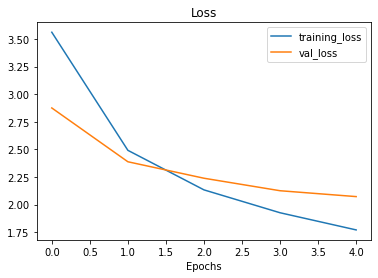

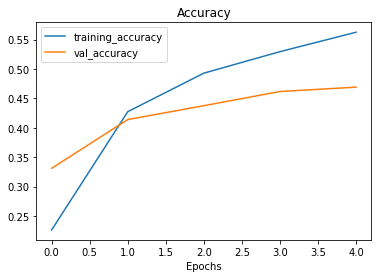

In [15]:
plot_loss_curves(history_all_classes_10_percent)

In [16]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [17]:
# Recompile the model with lower learning rate
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [18]:
# What layers are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)



input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling_layer True
output_layer True


In [19]:
# Which layers in base_model are trainable
for number, layer in enumerate(model.layers[2].layers):
  print(number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [20]:
 fine_tune_epoch = 10
 history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                      epochs=fine_tune_epoch,
                                                      validation_data=test_data,
                                                      validation_steps=int(0.15*len(test_data)),
                                                      initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 81s 307ms/step - loss: 1.5211 - accuracy: 0.6108 - val_loss: 2.0220 - val_accuracy: 0.4725
Epoch 6/10
237/237 [==============================] - 71s 296ms/step - loss: 1.3991 - accuracy: 0.6352 - val_loss: 2.0143 - val_accuracy: 0.4785
Epoch 7/10
237/237 [==============================] - 69s 288ms/step - loss: 1.3299 - accuracy: 0.6451 - val_loss: 2.0070 - val_accuracy: 0.4828
Epoch 8/10
237/237 [==============================] - 70s 292ms/step - loss: 1.2480 - accuracy: 0.6730 - val_loss: 2.0055 - val_accuracy: 0.4838
Epoch 9/10
237/237 [==============================] - 66s 276ms/step - loss: 1.2120 - accuracy: 0.6833 - val_loss: 2.0108 - val_accuracy: 0.4838
Epoch 10/10
237/237 [==============================] - 65s 272ms/step - loss: 1.1436 - accuracy: 0.6935 - val_loss: 1.9870 - val_accuracy: 0.4923


In [21]:
model.evaluate(test_data)

790/790 [==============================] - 101s 128ms/step - loss: 1.6856 - accuracy: 0.5568


[1.6855568885803223, 0.5568316578865051]